In [2]:
import pandas as pd
import joblib
from math import ceil
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt

def get_week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

In [3]:
#loading models
ws_model = joblib.load('../models/lgbm_weekly_sales.pkl')
ts_model = joblib.load('../models/lgbm_total_sales.pkl')
m1_model = joblib.load('../models/lgbm_markdown1.pkl')
m2_model = joblib.load('../models/lgbm_markdown2.pkl')
m3_model = joblib.load('../models/lgbm_markdown3.pkl')
m4_model = joblib.load('../models/lgbm_markdown4.pkl')
m5_model = joblib.load('../models/lgbm_markdown5.pkl')

col_pattern = joblib.load('../data/cols_pattern.pkl')
ts_col_pattern = joblib.load('../data/ts_cols_pattern.pkl')


## Checking predicted values for test set in 2012 year

In [4]:
df = pd.read_csv('../data/dummy_weekly_sales.csv')
df = df[df.year_2012==1]
X_test, y_test = df.drop('Weekly_Sales', axis=1), df[['Weekly_Sales']]
y_pred = ws_model.predict(X_test)
df_test = pd.concat([X_test.reset_index(drop = True), y_test.reset_index(drop=True), pd.DataFrame(y_pred, columns = ['prediction'])], axis = 1)
def undummy(df, col_pattern):
    return pd.DataFrame([x[-1] for x in df.filter(regex = col_pattern).idxmax(axis = 1).str.split('_')], columns = [col_pattern]).astype('int')

dummy_variables = ['year', 'month', 'week_of_year', 'week_of_month', 'store', 'dept']
undummied = df_test[['Weekly_Sales', 'prediction']].copy()

#### Here I create lineplots for weekly sales with store and department as args

<AxesSubplot:>

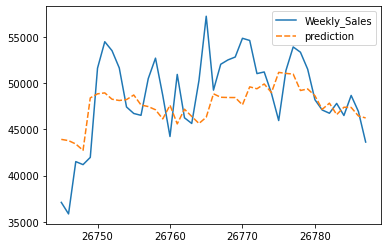

In [5]:
store = 10
department = 10
for var in dummy_variables:
    undummied[var] = undummy(df_test, var)
sns.lineplot(data = undummied.loc[(undummied.store == store)&(undummied.dept == department)][['Weekly_Sales', 'prediction']])

<AxesSubplot:>

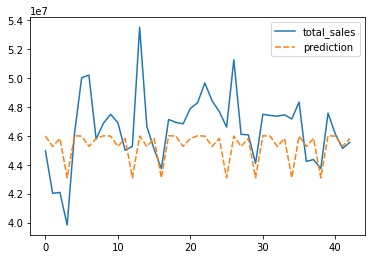

In [6]:
ts_model = joblib.load('../models/lgbm_total_sales.pkl')
df = pd.read_csv('../data/dummy_total_sales.csv')
df = df[df.year_2012==1]
X_test, y_test = df.drop('total_sales', axis=1), df[['total_sales']]
y_pred = ts_model.predict(X_test)
def undummy(df, col_pattern):
    return pd.DataFrame([x[-1] for x in df.filter(regex = col_pattern).idxmax(axis = 1).str.split('_')], columns = [col_pattern]).astype('int')

df_test = pd.concat([X_test.reset_index(drop = True), y_test.reset_index(drop=True), pd.DataFrame(y_pred, columns = ['prediction'])], axis = 1)
dummy_variables = ['year', 'month', 'week_of_year', 'week_of_month']
undummied = df_test[['total_sales', 'prediction']].copy()
for var in dummy_variables:
    undummied[var] = undummy(df_test, var)
sns.lineplot(data = undummied[['total_sales', 'prediction']])

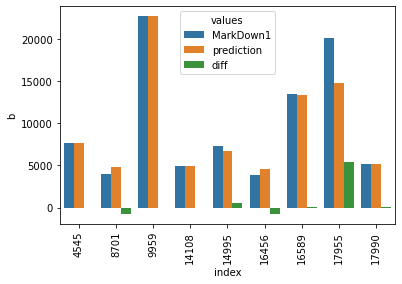

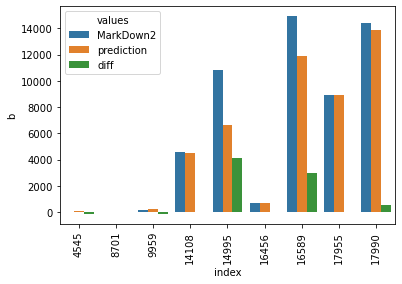

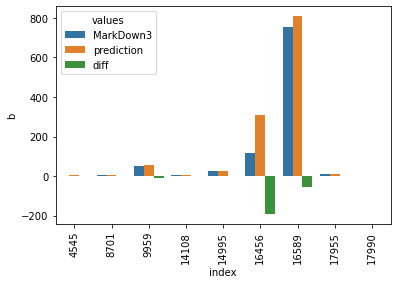

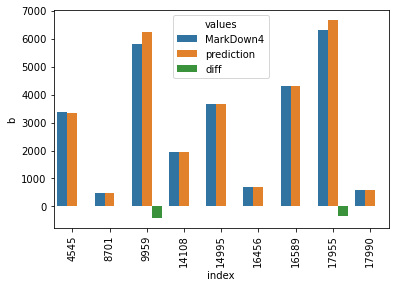

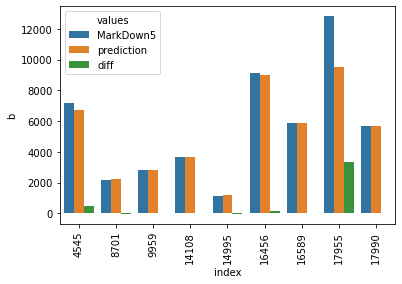

In [8]:
#I am using same seed as in the training script, so splitting for train/test is the same. As the data for markdowns was much more shorter, I am using random split, not as above when my test set was 2012 year.
dfm = pd.read_csv('../data/dummy_markdowns.csv')

for idx, m_model in enumerate([m1_model, m2_model, m3_model, m4_model, m5_model]):
        markdown = f'MarkDown{idx+1}'
        X_train, X_test, y_train, y_test = train_test_split(dfm.iloc[:,:-5], dfm[[markdown]], test_size=0.2, random_state=123)
        y_pred = m_model.predict(X_test)
        df_test = pd.concat([X_test.reset_index(drop = True), y_test.reset_index(drop=True), pd.DataFrame(y_pred, columns = ['prediction'])], axis = 1)
        dummy_variables = ['year', 'month', 'week_of_year', 'week_of_month', 'store', 'dept']
        undummied = df_test[[markdown,'prediction']].copy()
        for var in dummy_variables:
                undummied[var] = undummy(df_test, var)
        tmp = undummied.loc[(undummied.store == store)&(undummied.dept == department)]
        tmp['diff'] = tmp[markdown]-tmp.prediction
        tmp = tmp[[markdown, 'prediction', 'diff']].reset_index().melt('index', var_name='values', value_name='b')
        #sns.lineplot(data = undummied.loc[(undummied.store == store)&(undummied.dept == department)][[markdown, 'prediction']])
        #sns.lineplot(data = tmp[[markdown, 'prediction', 'diff']])
        ax=sns.barplot(x='index', y='b', hue='values', data=tmp)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        plt.show()

In [9]:
def predict_weekly_sales(year, month, day, store, dept):
    try:
        datetime.datetime(year=year,month=month,day=day)
    except:
        print('Invalid date')
        return
    date = pd.to_datetime(f'{day}/{month}/{year}', format='%d/%m/%Y')
    year = date.year
    month = date.month
    week_of_year = date.weekofyear
    week_of_month = get_week_of_month(date)
    #global dct
    dct = {f'year_{year}':1, f'month_{month}':1, f'week_of_year_{week_of_year}':1, f'week_of_month_{week_of_month}':1, f'store_{store}':1, f'dept_{dept}':1}
    df = pd.DataFrame.from_dict(dct, orient='index').T
    df[list(set(col_pattern)-set(dct.keys()))] = 0
    df = df.reindex(sorted(df.columns), axis=1)

    ts_dct = {f'year_{year}':1, f'month_{month}':1, f'week_of_year_{week_of_year}':1, f'week_of_month_{week_of_month}':1}
    ts_df = pd.DataFrame.from_dict(ts_dct, orient='index').T
    ts_df[list(set(ts_col_pattern)-set(ts_dct.keys()))] = 0
    ts_df = ts_df.reindex(sorted(ts_df.columns), axis=1)

    prediction = {
        'weekly_sales':int(ws_model.predict(df.values)[0]),
        'total_sales':int(ts_model.predict(ts_df.values)[0]),
        'markdown1':int(m1_model.predict(df.values)[0]),
        'markdown2':int(m2_model.predict(df.values)[0]),
        'markdown3':int(m3_model.predict(df.values)[0]),
        'markdown4':int(m4_model.predict(df.values)[0]),
        'markdown5':int(m5_model.predict(df.values)[0])
        }


    return prediction

#### Above there is function to predict sales and markdowns due to args: date, shop and department

In [10]:
year = 2013
month = 12
day = 30
store = 1
dept = 1

#### Models will predict 7 values - weekly sales and markdowns for store and department in given date and total sales.

In [11]:
predict_weekly_sales(year, month, day, store, dept)

{'weekly_sales': 32243,
 'total_sales': 45597452,
 'markdown1': 5575,
 'markdown2': 7057,
 'markdown3': 51,
 'markdown4': 1758,
 'markdown5': 6038}